# Category Mining #

In this project, we analyze a product-reviews dataset from the Amazon Kindle Store(e-books). The dataset consist of about 1 million product reviews, where for each review, a user rates a book on a scale of 1-5 and then writes a short comment. 

Note: This is a course project and still in progress.


## A. Assumptions and Hypothesis ##

We assume that we only know which users reviewed which e-books. Our hypothesis is that users interested in a certain type of book (e.g., books about sports) tend to rate and review similar books. We test this hypothesis, by running a _spectral co-clustering_ of a user-product graph to see how books cluster.

+ The clustering code comes from the [scikit-learn](https://scikit-learn.org/stable/) package. 
+ We prepare the data and process the results.

## B. Data

We are working with two dataset in this project. Both dataset are from dataset from the Amazon Kindle Store(e-books).
*The data originated with Julian McAuley [here](http://jmcauley.ucsd.edu/data/amazon/)*

### 1. Reviews dataset ###

Each element is an e-book review, stored as a dictionary. The most relevant keys are the following:

* `'reviewerID'`: An ID string for the user who wrote the review.
* `'asin'`: An ID string for the e-book that the user reviewed.
* `'overall'`: The reviewer's rating of the e-book, on a scale of 1.0 (hated the book) to 5.0 (loved the book). The value is shown and stored as a floating-point value, but the stored value is always an integer.
* `'reviewText'`: The reviewer's comments about the book, a string of arbitrary length.
* `'helpful'`: A two-element list. The first element is the number of other users who marked this review as being "helpful"; the second element is the number of users who looked at the review. For example, a value of `[4, 7]` means that 7 users read the review, but only 4 marked it as "helpful."


### 2. The second dataset is the metadata for e-books ###

For many of the e-books, there is also some additional metadata. We only need two pieces of information: 

* `'book ID'`: An ID string for the e-book that is available on Amazon Kindle Store.
* `'category'`: A list contaning the categories the product belongs to. We are interested in element 2 of the `'category'` value which represent **genre** of the e-books.

## C. Data preprocessing

Here we walk through the actual codes implemented to pre-process and the data.

### C-1. Setup ###

we start by loading some utilities and common modules.

In [1]:
print("loading some utilities and common modules")
global_overwrite = False
from pprint import pprint
import json
import re
import pandas as pd
import numpy as np
import scipy as sp

loading some utilities and common modules


### C-2: Reviews Dataset ###

The first part are the reviews. The code cell below loads them into a list of dictionaries named `raw_reviews`:

In [2]:
def load_json(filename):
    try:
        with open(filename, 'r') as f:
            data = [json.loads(line) for line in open(filename, 'r')]
            return data
    except IOError:
        raise "ERROR: Unable to locate file {}".format(filename)

In [3]:
print("loading data ...")
raw_reviews = load_json('kindle_reviews.json')

print(f'\n==> Found {len(raw_reviews):,} e-book reviews. Here are the first two:\n')
pprint(raw_reviews[:2])

loading data ...

==> Found 982,619 e-book reviews. Here are the first two:

[{'asin': 'B000F83SZQ',
  'helpful': [0, 0],
  'overall': 5.0,
  'reviewText': 'I enjoy vintage books and movies so I enjoyed reading this '
                "book.  The plot was unusual.  Don't think killing someone in "
                'self-defense but leaving the scene and the body without '
                'notifying the police or hitting someone in the jaw to knock '
                'them out would wash today.Still it was a good read for me.',
  'reviewTime': '05 5, 2014',
  'reviewerID': 'A1F6404F1VG29J',
  'reviewerName': 'Avidreader',
  'summary': 'Nice vintage story',
  'unixReviewTime': 1399248000},
 {'asin': 'B000F83SZQ',
  'helpful': [2, 2],
  'overall': 4.0,
  'reviewText': 'This book is a reissue of an old one; the author was born in '
                "1910. It's of the era of, say, Nero Wolfe. The introduction "
                'was quite interesting, explaining who the author was and why '
    

#### reviews_to_df: Convert the reviews into a pandas data frame ####

Given a raw reviews dataset named `reviews`, which is a list of dictionaries like the one shown above, `reviews_to_df(reviews)` converts it to a pandas `DataFrame` object and return that dataframe. Each row of the dataframe will be a book review and has **six** columns, constructed as follows:

1. `'reviewer'`: A string ID for the reviewer, which is the value of `'reviewerID'`
2. `'ebook'`: A string ID for the e-book, which is the value of `'asin'`
3. `'rating'`: An **integer** value, which is the `'overall'` rating converted into an integer value
4. `'text'`: A string holding the reviewer's text comments, taken from `'reviewText'`
5. `'num_helpful'`: An integer for the number of users who thought the review was helpful, taken from the first field of the `'helpful'` value
6. `'num_evals'`: An integer for the number of users who evaluated the review, taken from the second field of the `'helpful'` value

For example, suppose `reviews` has exactly these two elements:

```python
[{'asin': 'B000F83SZQ', 'helpful': [0, 0], 'overall': 5.0, 'reviewerID': 'A1F6404F1VG29J',
  'reviewText': 'I enjoy vintage books ... good read for me.',
  ... },
 {'asin': 'B000F83SZQ', 'helpful': [2, 2], 'overall': 4.0, 'reviewerID': 'AN0N05A9LIJEQ',
  'reviewText': 'This book is ... well worth a look-see.',
  ...}
]
```

Then the output would be a `DataFrame` of the form:

|    | reviewer       | ebook      |   rating | text                                        |   num_helpful |   num_evals |
|---:|:---------------|:-----------|---------:|:--------------------------------------------|--------------:|------------:|
|  0 | A1F6404F1VG29J | B000F83SZQ |        5 | I enjoy vintage books ... good read for me. |             0 |           0 |
|  1 | AN0N05A9LIJEQ  | B000F83SZQ |        4 | This book is ... well worth a look-see.     |             2 |           2 |


In [4]:
def reviews_to_df(reviews):
    data = [[review['reviewerID'],review['asin'],review['overall'],
            review['reviewText'],review['helpful'][0],review['helpful'][1]]
            for review in reviews
           ]
    df = pd.DataFrame(data, columns =['reviewer','ebook','rating','text','num_helpful','num_evals'])
    
    return df

In [5]:
# Demo:
ex1_demo_reviews = \
    [{'asin': 'B000F83SZQ', 'helpful': [0, 0], 'overall': 5.0, 'reviewerID': 'A1F6404F1VG29J',
      'reviewText': 'I enjoy vintage books ... good read for me.'},
     {'asin': 'B000F83SZQ', 'helpful': [2, 2], 'overall': 4.0, 'reviewerID': 'AN0N05A9LIJEQ',
      'reviewText': 'This book is ... well worth a look-see.'}]

reviews_to_df(ex1_demo_reviews)

,reviewer,ebook,rating,text,num_helpful,num_evals
0,A1F6404F1VG29J,B000F83SZQ,5.0,I enjoy vintage books ... good read for me.,0,0
1,AN0N05A9LIJEQ,B000F83SZQ,4.0,This book is ... well worth a look-see.,2,2


####  `reviews_to_df` => `reviews_df` ####

We use `reviews_to_df(reviews)` to generate a reviews `DataFrame` from the `raw_reviews` input which will be stored in the global variable, `reviews_df`.

In [6]:
print("Convert review list to DataFrame ...")
reviews_df = reviews_to_df(raw_reviews)

print("\nExamples:")
display(reviews_df.head())
    


Convert review list to DataFrame ...

Examples:


,reviewer,ebook,rating,text,num_helpful,num_evals
0,A1F6404F1VG29J,B000F83SZQ,5.0,I enjoy vintage books and movies so I enjoyed ...,0,0
1,AN0N05A9LIJEQ,B000F83SZQ,4.0,This book is a reissue of an old one; the auth...,2,2
2,A795DMNCJILA6,B000F83SZQ,4.0,This was a fairly interesting read. It had ol...,2,2
3,A1FV0SX13TWVXQ,B000F83SZQ,5.0,I'd never read any of the Amy Brewster mysteri...,1,1
4,A3SPTOKDG7WBLN,B000F83SZQ,4.0,"If you like period pieces - clothing, lingo, y...",0,1


In [8]:
print("\nDeleting `raw_reviews`...")
if 'raw_reviews' in globals(): del raw_reviews
print('Done.')


Deleting `raw_reviews`...
Done.


### C-2: E-book metadata ###

For many of the e-books, there is also some additional metadata. Run the code cell below, which will load these metadata separately into a list of nested dictionaries called `raw_metadata`:

In [9]:
print(" Loading the E-book metadata ... ")
raw_metadata = load_json('kindle_metadata.json')
print(f'\n==> Found {len(raw_metadata):,} e-books.')

 Loading the E-book metadata ... 

==> Found 491,670 e-books.


These data are messy. Here is what it looks like for one e-book:

In [10]:
pprint(raw_metadata[0])

{'also_buy': ['B007NLCJBC', 'B01FARODH8'],
 'also_view': ['B000FBF81K', 'B00PBDMER8'],
 'asin': 'B000FA5KKA',
 'brand': 'Arthur K. Barnes',
 'category': ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy'],
 'date': '',
 'description': [],
 'details': {'ASIN:': 'B000FA5KKA',
             'File Size:': '295 KB',
             'Language:': 'English',
             'Lending:': 'Enabled',
             'Print Length:': '113 pages',
             'Publication Date:': 'October 14, 2001',
             'Publisher:': 'FuturesPast Editions (October 14, 2001)',
             'Word Wise:': 'Enabled'},
 'feature': [],
 'fit': '',
 'imageURL': [],
 'imageURLHighRes': [],
 'main_cat': 'Buy a Kindle',
 'price': '',
 'rank': '1,716,849 Paid in Kindle Store (',
 'similar_item': '',
 'tech1': '',
 'tech2': '',
 'title': ''}


For our analyses, we only need two pieces of information: the **book ID** (the first `'asin'` value) and the **genre** (element 2 of the `'category'` value, which has 3 elements in the above example).

The problem is that the genres can be messy. Here are some examples of what can appear in the category list:

In [11]:
print('   4:', raw_metadata[4]['category']) # Looks fine ...
print('   1:', raw_metadata[1]['category']) # 4 elements; but element 2 is still valid
print(' 244:', raw_metadata[244]['category']) # 2 elements
print('2890:', raw_metadata[2890]['category']) # 3 elements, but element 2 has "junk" in it
print('   9:', raw_metadata[9]['category']) # 3 elements, but element 2 has '&amp;' instead of '&'

   4: ['Kindle Store', 'Kindle eBooks', 'Business & Money']
   1: ['Kindle Store', 'Kindle eBooks', 'Engineering & Transportation', '</span>']
 244: ['Kindle Store', 'Kindle eBooks']
2890: ['Kindle Store', 'Kindle eBooks', '</span>']
   9: ['Kindle Store', 'Kindle eBooks', 'Business &amp; Money']


Examples 4, 1, and 9 above have usable genres, but 244 and 2890 do not.

#### `reviews_to_df(reviews)`: Subselect e-books with usable genres ####

Given a collection of metadata named `metadata`, which is formatted like what you see above, `metadata_to_df(metadata)` creates and returns a new pandas `DataFrame` containing only those e-books with **usable genres**. The new dataframe should have one row per e-book. It should also have two columns:

1. `'ebook'`, a string ID for the e-book, taken from the first `'asin'` field
2. `'genre'`, a **cleaned** genre string, taken from element 2 of the `'category'` value

**Usable genres** 
For any e-book, we will say that it has a **usable genre** if the following conditions hold:

1. Its `'category'` list has **at least** three elements (`>= 3`).
2. The first two elements of the `'category'` list **equal** `'Kindle Store'` and `'Kindle eBooks'`, respectively.
3. The third element does **not** contain any angle brackets (`'<'` and `'>'`).

**Cleaned genre string**
A cleaned genre string is one where any instance of the substring, `&amp;`, is replaced by `&`. For example, if the input genre string is `'Business &amp; Money'`, then its cleaned version is `'Business & Money'`.

**Example.** 
Suppose `metadata` equals the following:

```python
    [{'asin': 'B000FA5KKA',
      'category': ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy']},
     {'asin': 'B000FA5M3K',
      'category': ['Kindle Store', 'Kindle eBooks', 'Engineering & Transportation', '</span>']},
     {'asin': 'B000FA5KX2',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business & Money']},
     {'asin': 'B000FA5L2C',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business &amp; Money']},
     {'asin': 'B000FC2LCS',
      'category': ['Kindle Store', 'Kindle eBooks']},
     {'asin': 'B001CBBL7M',
      'category': ['Kindle Store', 'Kindle eBooks', '</span>']}]
```

Then `metadata_to_df(metadata)` would return a dataframe equivalent to this one:

|    | ebook      | genre                        |
|---:|:-----------|:-----------------------------|
|  0 | B000FA5KKA | Science Fiction & Fantasy    |
|  1 | B000FA5M3K | Engineering & Transportation |
|  2 | B000FA5KX2 | Business & Money             |
|  3 | B000FA5L2C | Business & Money             |


In [45]:
def metadata_to_df(metadata):
    data = [[ebook['asin'],ebook['category'][2].replace("&amp;","&")] 
            for ebook in metadata
            if ((len(ebook['category'])>=3)
                 and (ebook['category'][0:2] == ['Kindle Store', 'Kindle eBooks'])
                 and not any(c in ['<' , '>'] for c in ebook['category'][2]) 
                ) 
           ]

    df = pd.DataFrame(data, columns =['ebook','genre'])
    return df


In [46]:
# Demo
ex1_demo_metadata = \
    [{'asin': 'B000FA5KKA',
      'category': ['Kindle Store', 'Kindle eBooks', 'Science Fiction & Fantasy']},
     {'asin': 'B000FA5M3K',
      'category': ['Kindle Store', 'Kindle eBooks', 'Engineering & Transportation', '</span>']},
     {'asin': 'B000FA5KX2',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business & Money']},
     {'asin': 'B000FA5L2C',
      'category': ['Kindle Store', 'Kindle eBooks', 'Business &amp; Money']},
     {'asin': 'B000FC2LCS',
      'category': ['Kindle Store', 'Kindle eBooks']},
     {'asin': 'B001CBBL7M',
      'category': ['Kindle Store', 'Kindle eBooks', '</span>']}]

print(metadata_to_df(ex1_demo_metadata))

        ebook                         genre
0  B000FA5KKA     Science Fiction & Fantasy
1  B000FA5M3K  Engineering & Transportation
2  B000FA5KX2              Business & Money
3  B000FA5L2C              Business & Money


#### `metadata_to_df` => `metadata_df` ####

We use `metadata_to_df` to generate a metadata dataframe from the `raw_metadata` input which will be stored in the global variable, `metadata_df`. We also **delete** the original `raw_metadata` input to help save memory.

In [14]:
metadata_df = metadata_to_df(raw_metadata)
print("\nExamples:")
display(metadata_df.head())

print(f"\nThere are {len(metadata_df['genre'].unique())} unique genres.")
    



Examples:


,ebook,genre
0,B000FA5KKA,Science Fiction & Fantasy
1,B000FA5M3K,Engineering & Transportation
2,B000FA5KJQ,Biographies & Memoirs
3,B000FA5NSO,Science Fiction & Fantasy
4,B000FA5KX2,Business & Money



There are 33 unique genres.


In [16]:
print("\nDeleting `raw_metadata`...")
if 'raw_metadata' in globals(): del raw_metadata
print('Done.')


Deleting `raw_metadata`...
Done.


### C-3  Combining the data ###

We now combine these separate dataframes into a single one. `combine_dfs(reviews_df, metadata_df)` returns a new dataframe with the following properties:

1. There is one review per row
2. The dataframe has seven (7) columns, which essentially combine all columns from the two dataframes: `'reviewer'`, `'ebook'`, `'rating'`, `'text'`, `'num_helpful'`, `'num_evals'`, and `'genre'`
3. Any review whose `'ebook'` is **missing** from `metadata_df` should be omitted.

In [17]:
def combine_dfs(reviews_df, metadata_df):
    # df = pd.merge(reviews_df, metadata_df, left_on= 'asin', right_on= 'ebook', how = 'inner')
    df = pd.merge(reviews_df, metadata_df, on= 'ebook', how = 'inner')
    return df

In [18]:
# Demo: Should reduce the number of reviews to `484,708`
print(f"`reviews_df` has {len(reviews_df):,} reviews (rows).\n")
combined_df = combine_dfs(reviews_df, metadata_df)
print(combined_df.columns)
ex2_demo_result = len(combined_df)
print(f"Combining with `metadata_df` leaves {ex2_demo_result:,} reviews.")

`reviews_df` has 982,619 reviews (rows).

Index(['reviewer', 'ebook', 'rating', 'text', 'num_helpful', 'num_evals',
       'genre'],
      dtype='object')
Combining with `metadata_df` leaves 484,708 reviews.


#### `combine_dfs` => `combined_df` ####

We use `combine_dfs` to generate a combined input which will be stored in the global variable, `combined_df`. We also **delete** `reviews_df` to help save memory.

In [19]:
print("\nExamples:")
display(combined_df.head())
    
print("\nDeleting `reviews_df` ...")
if 'reviews_df' in globals(): del reviews_df
print('Done.')


Examples:


,reviewer,ebook,rating,text,num_helpful,num_evals,genre
0,A3SZMGJMV0G16C,B000FA64PK,3.0,Troy Denning's novella Recovery was originally...,0,0,Literature & Fiction
1,A3H8PE1UFK04JZ,B000FA64PK,5.0,I am not for sure on how much of a difference ...,0,0,Literature & Fiction
2,A2EN84QHDRZLP2,B000FA64PK,5.0,I really enjoyed the book. Had the normal back...,0,0,Literature & Fiction
3,A1UG4Q4D3OAH3A,B000FA64PK,5.0,Great read enjoyed every minute of it . I thi...,0,0,Literature & Fiction
4,A38Z3Q6DTDIH9J,B000FA64PK,3.0,"Another well written eBook by Troy Denning, bu...",4,4,Literature & Fiction



Deleting `reviews_df` ...
Done.


## D. Discovering genres ##

Each review connects a user to a book, and we want to perform **biclustering** on thos combined dataset.

+ We want to cluster users into groups based on what books they reviewed; or similarly 
+ We want to cluster books together based on who reviewed them. 

### D-1. Discovering genres ###

To do a biclustering, we first need to build a (sparse) matrix that encodes these connections. Here is one way. Let $A$ an $m \times n$ matrix of $m$ users (rows) and $n$ books (columns). Let each entry $a_{i, j}$ be the rating that user $i$ gave to book $j$. With such a matrix, we can then use a biclustering algorithm called _spectral co-clustering_ to construct both user-user and book-book clusters.

#### `create_map(x)`: Map string IDs to logical indices ####

Given a pandas `Series` object, `x`, whose values are strings, `create_map(x)`constructs and returns a Python dictionary that maps `x`-values (keys) to integers (values) as the following:

1. It determines the unique values in `x`.
2. It sorts these unique values in ascending order.
3. It assigns each unique value to a unique integer, starting from 0 and corresponding to the value's position in sorted order.

In [21]:
def create_map(x):
    assert isinstance(x, pd.Series)
    sorted_x = x.drop_duplicates(keep='first').sort_values(ascending=True).reset_index(drop=True)
    return pd.Series(sorted_x.index.values, index=sorted_x ).to_dict()  

In [22]:
# Demo
ex3_demo_input = pd.Series(['cat', 'dog', 'cat', 'cat', 'aardvark', 'dog', 'anemone', 'aardvark'])
demo_dict = create_map(ex3_demo_input)
print(demo_dict)

{'aardvark': 0, 'anemone': 1, 'cat': 2, 'dog': 3}


#### `create_map` => `reviewer_map` and `ebook_map` ####

We use `create_map` to generate index maps for both reviewers and e-books which create two value-to-index maps: `reviewer_map` for users (reviewers) and `ebook_map` for e-books.

In [23]:
reviewer_map = create_map(combined_df['reviewer'])
ebook_map = create_map(combined_df['ebook'])
print('A3SZMGJMV0G16C', "==>", reviewer_map['A3SZMGJMV0G16C'])
print('B000FA64PK', "==>", ebook_map['B000FA64PK'])

A3SZMGJMV0G16C ==> 49003
B000FA64PK ==> 0


#### `ratings_to_coo(ratings, r_map, e_map)`: Building a sparse matrix ####

Given string-to-integer maps for reviewers and e-books, as `r_map` and `e_map`, respectively, and a dataframe, `ratings`, with three columns:

* `'reviewer'`: The string ID of a user
* `'ebook'`: The string ID of a book that the user rated
* `'rating'`: The value of the user's rating, which is an integer from 1 to 5.

`ratings_to_coo(ratings, r_map, e_map)` returns a Scipy sparse matrix in COO (coordinate) format, constructed according to these rules:

1. Let `(r, e, v)` denote the values of `'reviewer'`, `'ebook'`, and `'rating'` in a row of `ratings`. Each row will be a nonzero of the sparse matrix.
2. The reviewer with string ID `r` corresponds to row `i = r_map[r]` of the sparse matrix.
3. An e-book with string ID `e` corresponds to column `j = e_map[e]` of the sparse matrix.
4. The `(i, j)` entry of the sparse matrix is `v`.

First, We imports [Scipy's `coo_matrix` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html), which we use to construct the matrix. 

**Example.** 

Suppose `ratings` is as follows:

| reviewer   | ebook   |   rating |
|:-----------|:--------|---------:|
| alice      | happy   |        5 |
| bob        | sad     |        2 |
| carol      | happy   |        5 |
| dave       | happy   |        4 |
| edith      | sad     |        1 |

Next, suppose `r_map` and `e_map` are as follows:

```python
r_map = {'alice': 0, 'bob': 1, 'carol': 2, 'dave': 3, 'edith': 4}
e_map = {'happy': 0, 'sad': 1}
```

Then the sparse matrix would have a structure that looks like the following (rendered here as a table for ease of visualization):

|         | _col 0_ | _col 1_ |
|:-------:|:-------:|:-------:|
| _row 0_ |    5    |         |
| _row 1_ |         |    2    |
| _row 2_ |    5    |         |
| _row 3_ |    4    |         |
| _row 4_ |         |    1    |



In [24]:
def ratings_to_coo(ratings, r_map, e_map):
    from scipy.sparse import coo_matrix
    
    # Precompute the matrix shape, `m` rows by `n` columns:
    m, n = max(r_map.values())+1, max(e_map.values())+1
    row = [r_map[r] for r in ratings['reviewer']]
    col = [e_map[e] for e in ratings['ebook']]
    data = [v for v in ratings['rating']]

    ratings_coo = coo_matrix((data, (row, col)), shape=(m, n))
    
    return ratings_coo


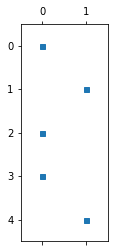

In [25]:
# Demo:
import matplotlib.pylab as plt

ex4_demo_ratings = pd.DataFrame({'reviewer': ['alice', 'bob', 'carol', 'dave', 'edith'],
                                 'ebook': ['happy', 'sad', 'happy', 'happy', 'sad'],
                                 'rating': [5, 2, 5, 4, 1]})
ex4_demo_r_map = {'alice': 0, 'bob': 1, 'carol': 2, 'dave': 3, 'edith': 4}
ex4_demo_e_map = {'happy': 0, 'sad': 1}

ex4_demo_matrix = ratings_to_coo(ex4_demo_ratings, ex4_demo_r_map, ex4_demo_e_map)
plt.spy(ex4_demo_matrix, markersize=5)

#### `ratings_to_coo` => `ratings_matrix` ####

We use `ratings_to_coo` to generate a sparse matrix for the Amazon Kindle ratings data which is stored in the variable, `ratings_matrix`.

In [26]:
ratings_matrix = ratings_to_coo(combined_df[['reviewer', 'ebook','rating']], reviewer_map, ebook_map)

The `ratings_matrix` is (65,997 users) x (31,765 e-books), with 484,708 nonzero ratings.
Here is a picture:


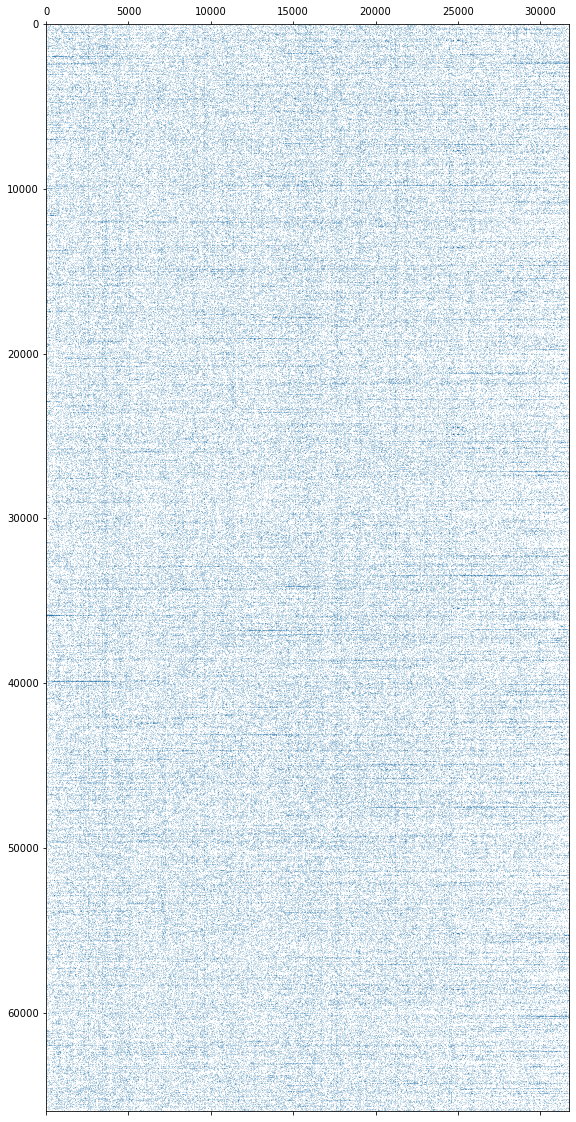

In [27]:
print(f"The `ratings_matrix` is ({ratings_matrix.shape[0]:,} users) x ({ratings_matrix.shape[1]:,} e-books), with {ratings_matrix.nnz:,} nonzero ratings.")
print("Here is a picture:")
plt.figure(figsize=(20,20)) 
plt.spy (ratings_matrix, markersize=0.05)

### D-2. Spectral co-clustering ####

The `scikit-learn` package provides a spectral co-clustering implementation. It takes the sparse matrix as input, as well as a target number of clusters; it returns an assignment of rows and columns to clusters.

Based on our analysis, there are roughly 30 different usable genres, so let's ask for 30 clusters. The output will consist of two sets of labels, one for users (in a Numpy array named `row_labels`, below) and one for e-books (`col_labels`).

In [28]:
def bicluster(matrix, num_clusters=10, verbose=True):
    from sklearn.cluster import SpectralCoclustering
    if verbose:
        print("Performing a biclustering...")
        print(f"* Input matrix shape: {matrix.shape[0]:,} x {matrix.shape[1]:,}")
        print(f"* Number of nonzeros: {matrix.nnz:,}")
        print(f"* Desired number of clusters: {num_clusters}")
    clustering = SpectralCoclustering(n_clusters=num_clusters, random_state=0).fit(matrix)
    if verbose:
        print("==> Done!")
    return clustering.row_labels_, clustering.column_labels_


row_labels, col_labels = bicluster(ratings_matrix, num_clusters=30)

Performing a biclustering...
* Input matrix shape: 65,997 x 31,765
* Number of nonzeros: 484,708
* Desired number of clusters: 30
==> Done!


Let's focus on the e-book (column) labels. Here are the computed labels for the first eight e-books:

In [29]:
print(f"\nHere are the first few column (e-book) labels: {col_labels[:8]}")


Here are the first few column (e-book) labels: [24 24 24 24 25 25  0 25]


The labels are arbitrary integers. E-books belonging to the same cluster will have the same label.

####  `map_labels(x_map, labels)`: Postprocessing the results ####

Given two inputs, `x_map` and `labels`, formatted as follows:

- `x_map` is a dictionary just like `reviewer_map` and `ebook_map` from Exercise 3: each key `s` is a string ID, and the corresponding value `i = x_map[s]` is its integer index.
- `labels` is a Numpy array holding cluster labels. For an integer index `i`, the value `labels[i]` is the label assigned to `i`.

`map_labels(x_map, labels)` returns a Python dictionary where each key is a string label `s` and the value is its assigned label.

In [30]:
def map_labels(x_map, labels):
    labels_dict = {key:labels[value] for (key,value) in x_map.items() }
    return labels_dict

In [31]:
# Demo:
ex5_demo_x_map = {'alice': 0, 'bob': 1, 'carol': 2, 'dave': 3, 'edith': 4}
ex5_demo_labels = np.array([1, 0, 1, 1, 0])
print(map_labels(ex5_demo_x_map, ex5_demo_labels))

{'alice': 1, 'bob': 0, 'carol': 1, 'dave': 1, 'edith': 0}


#### `map_labels` => `ebook_labels` ####

We use `map_labels` to map the e-book labels back to each book's string ID which creates the e-book label map, `ebook_labels`.

In [32]:
ebook_labels = map_labels(ebook_map, col_labels)

print("Some of the assigned labels:")
for ebook_id in ['B00IK5B0LK', 'B00AQNPV0K', 'B007Z3S0NE', 'B0075VFMCI', 'B00C404E60']:
    print(f"* '{ebook_id}' ==> label {ebook_labels[ebook_id]}")

Some of the assigned labels:
* 'B00IK5B0LK' ==> label 11
* 'B00AQNPV0K' ==> label 0
* 'B007Z3S0NE' ==> label 25
* 'B0075VFMCI' ==> label 0
* 'B00C404E60' ==> label 11


## E. Cluster analysis ##

Let's inspect the e-book clusters and see what they reveal.

### E-1. k-largest clusters ###

Given a Numpy array of cluster labels called `labels` and an integer `k >= 1`, `top_k_labels(labels, k)`, returns a **Python set** containing the `k` most frequent labels

1. it counts how many times each label occurs.
2. ranks the labels from most-to-least frequent.
3. In the case of ties, we include all labels with the same count. Therefore, we might return more than `k` labels. And if there are fewer than `k` distinct labels, then we should return them all.

**Example.**  

Consider the array,

```python
labels = np.array([5, 3, 5, 5, 0, 6, 6, 4, 1, 1, 4, 7, 5, 6])
```

Observe that 5 appears four times, 6 appears three times, 1 and 4 both appear twice, and 0, 3, and 7 appear once each. Therefore:

- If `k=1`, your function would return the set `{5}`.
- If `k=2`, your function would return the set `{5, 6}`.
- If `k=3`, your function would return the set `{5, 6, 1, 4}`. That is, even though the caller only asked for the top 3, there is a tie for third place.
- If `k=4`, your function would again return `{5, 6, 1, 4}`.
- For any `k >= 5`, your function would return all unique values, `{5, 6, 1, 4, 0, 3, 7}`.



In [33]:
def top_k_labels(labels, k):
    assert isinstance(labels, np.ndarray)
    top_k_labels = pd.value_counts(pd.Series(labels)).nlargest(n=k, keep='all').index.values
    return set(top_k_labels)

In [34]:
# Demo:
ex6_demo_labels = np.array([5, 3, 5, 5, 0, 6, 6, 4, 1, 1, 4, 7, 5, 6])
print("* Input:", ex6_demo_labels)
print("* Your output:")
for k in range(1, 10):
    print(f"k={k} ==>", top_k_labels(ex6_demo_labels, k))

* Input: [5 3 5 5 0 6 6 4 1 1 4 7 5 6]
* Your output:
k=1 ==> {5}
k=2 ==> {5, 6}
k=3 ==> {1, 4, 5, 6}
k=4 ==> {1, 4, 5, 6}
k=5 ==> {0, 1, 3, 4, 5, 6, 7}
k=6 ==> {0, 1, 3, 4, 5, 6, 7}
k=7 ==> {0, 1, 3, 4, 5, 6, 7}
k=8 ==> {0, 1, 3, 4, 5, 6, 7}
k=9 ==> {0, 1, 3, 4, 5, 6, 7}


#### `top_k_labels` => `top_k_ebook_labels` ####

We use  `top_k_labels` to identify the top `k` e-book labels.

In [35]:
top_k_ebook_labels = top_k_labels(col_labels, k=10)
print(f"The top {len(top_k_ebook_labels)} most frequent e-book labels:")
print(top_k_ebook_labels)

The top 10 most frequent e-book labels:
{0, 9, 11, 14, 15, 17, 19, 20, 22, 25}


### E-2. Top genres in each cluster ###

Recall that our analysis has assigned some of the e-books to clusters (`ebook_labels`). Each of these e-books is associated with a genre, available in the metadata dataframe.

####  `merge_labels(metadata, ebook_labels)`:  Combine metadata with Lables ####

Given an e-book-to-label mapping, `ebook_labels`, and an e-book metadata dataframe, `metadata`, `merge_labels(metadata, ebook_labels)`constructs a new dataframe with three columns: `'ebook'`, `'genre'`, and `'label'`:

1. The `'ebook'` and `'genre'` columns come from `metadata`. 
2. The `'label'` column comes from `ebook_labels`. 
3. Not all e-books in `metadata` will have labels. The new dataframe  **only** include e-books with labels; any other e-book should not appear in it.

In [38]:
def merge_labels(metadata, ebook_labels):
    ebook_labels_df = pd.DataFrame(ebook_labels.items(), columns= ['ebook', 'label']).set_index('ebook')
    metadata_labels = pd.merge(metadata, ebook_labels_df, on= 'ebook', how = 'inner')
    return metadata_labels

#### `merge_labels` => `labeled_metadata_df` ####

We use `merge_labels` to merge `ebook_labels` with `metadata_df` and create the labeled metadata dataframe, named `labeled_metadata_df`.

In [39]:
labeled_metadata_df = merge_labels(metadata_df, ebook_labels)
labeled_metadata_df.head()

,ebook,genre,label
0,B000FA64PK,Literature & Fiction,24
1,B000FA64QO,Science Fiction & Fantasy,24
2,B000FBFMVG,Literature & Fiction,24
3,B000JMKNQ0,Literature & Fiction,24
4,B000JMKX4W,Literature & Fiction,25


In [40]:
labeled_metadata_df.sample(5)

,ebook,genre,label
9249,B009JYEIPQ,Medical eBooks,14
24154,B00H9P7XW2,Romance,25
28611,B00JI12AFU,Romance,0
26009,B00I59VGG0,Teen & Young Adult,11
17627,B00DJL3CP2,Literature & Fiction,0


### E-3. Genre features ###

We now have the building blocks to inspect some simple features of each cluster, to see how "distinct" clusters are from one another. Let's do that by analyzing the top genres represented in each cluster.

First, recall that you previously identified the largest clusters:

In [41]:
top_k_ebook_labels

{0, 9, 11, 14, 15, 17, 19, 20, 22, 25}

Next, recall that we assigned e-books to clusters:

In [42]:
labeled_metadata_df.head(5)

,ebook,genre,label
0,B000FA64PK,Literature & Fiction,24
1,B000FA64QO,Science Fiction & Fantasy,24
2,B000FBFMVG,Literature & Fiction,24
3,B000JMKNQ0,Literature & Fiction,24
4,B000JMKX4W,Literature & Fiction,25


####  `calc_top_genres(labeled_metadata, top_labels)`:  Combine metadata with Lables ####

Given the following two objects as input:

- `labeled_metadata`: A pandas dataframe, formatted like `labeled_metadata_df` above.
- `top_labels`: A Python set of labels, like `top_k_ebook_labels` above.

`calc_top_genres(labeled_metadata, top_labels)` should then do the following:

- For each label in `top_labels`, it should determine the **two** most frequently occurring genres among the e-books with that label.
- It should then return a single dataframe with two columns, `'label'` and `'genre'`. Each row should correspond to one (label, genre) pair. And per the preceding bullet, you expect to see two rows per label.

Regarding the number of rows per label, there are two exceptions. First, if a given label only has e-books from one genre, then there will only be one row. Second, if there are ties, then we retain all pairs

In [43]:
def calc_top_genres(labeled_metadata, top_labels):
    df = labeled_metadata.copy()
    # group by 'label','genre and then saving the count as new column
    df = df.groupby(by = ['label','genre'], as_index=True).count().reset_index()
    # now for each label, we apply nlargest(2) based on the number of ebooks
    df = df.groupby(by=['label'], as_index=True)[['genre','ebook']].apply(lambda x: x.nlargest(2, columns = 'ebook')).reset_index()
    
    return df[['label','genre']]



#### `calc_top_genres` => `top_cluster_genres` ####

We use `calc_top_genres` to determine the top genres in each cluster by combining `labeled_metadata_df` with `top_k_ebook_labels`, and create the dataframe, named `top_cluster_genres`.

In [47]:
top_cluster_genres = calc_top_genres(labeled_metadata_df, top_k_ebook_labels)
print("* The top genres in each of the largest few clusters:")
display(top_cluster_genres)

* The top genres in each of the largest few clusters:


,label,genre
0,0,Literature & Fiction
1,0,Romance
2,1,Religion & Spirituality
3,2,Sports & Outdoors
4,2,Arts & Photography
5,3,"Cookbooks, Food & Wine"
6,4,Children's eBooks
7,5,Literature & Fiction
8,5,"Comics, Manga & Graphic Novels"
9,6,"Health, Fitness & Dieting"


### This project is in progress ###